*'The best time to buy a home is always five years ago'*

*Ray Brown*

# Ames (Iowa, US) Housing market - analysis & prediction

## Introduction

As a house buyer/seller, we always want to get the best deal - either maximize the profit or purchase the best house that will meet our expectation for the lowest price.

In both cases, people made significant research - they spend time comparing other houses available on the market and researching the area in which the house is located.

In the following research material, we will analyse exhausting dataset of housing market that originally appeared in Dean De Cock journal paper. It contains 80 different features, as well as the price of the properties located in the Ames, Iowa in the USA.

The dataset with description competition is available on the Kaggle website: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [9]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
import sys

sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

Dataset used in the following analysis is a CSV file of size 1461x81. 

In [2]:
from house_prices_advanced_regression_techniques.load_data import load_data


train_set = load_data('./dataset', 'train.csv')
train_set_raw = load_data('./dataset', 'train.csv', keep_na=False)

### Dataset

In [3]:
train_set_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


Just a brief look at the first rows shows the exhaustive complexity of the dataset.

Some of the columns like *Street*, *YrSold*, or *SalePrice* are self-explaining, whereas most columns looks a bit more vague. The description for all columns is located in **data_description.txt** file located in **/dataset**. Before proceeding, we shall try to understand at least some of the columns.

To start with, the column *LandContour* describes flatness of the property:

| Code |                            Description                            |
|:----:|:-----------------------------------------------------------------:|
|  Lvl |                          Near Flat/Level                          |
|  Bnk | Banked - Quick and significant rise from street grade to building |
|  HLS |           Hillside - Significant slope from side to side          |
|  Low |                             Depression                            |

Another interesting example might be **PoolQC**. Taking a brief look at the readme file quickly dispels doubts about it's meaning:

PoolQC: Pool quality

| Ex |    Excellent    |
|:--:|:---------------:|
| Gd |       Good      |
| TA | Average/Typical |
| Fa |       Fair      |
| NA |     No Pool     |

PoolQC column also shows that the column type was not properly set by Pandas Dataframe - NA value was translated to NaN, which also means that the data preparation will be needed.

## Basic visualization

The most important feature of each training example is the label - the below calculations shows us the most important characteristics.

In [4]:
train_set['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Price distribution

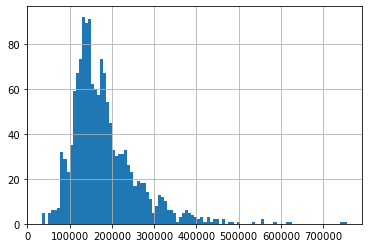

In [5]:
train_set['SalePrice'].hist(bins=100);

Even the very basic analysis provides quite a lot of useful information. Vast majority of houses were sold for a price between 100,000 US dollars and 200,000 US dollars. The cheapest house was sold for just 34,900 US dollars whereas the most expensive one for outstanding 755,000 US dollars.

The problem with this histogram is that is moved towards the left side of the plot which will affect the predictions. Skew can be calculated using Pandas - skew that is equal to 0 means the histogram is a perfect normal distribution.

In [6]:
skew = train_set['SalePrice'].skew()
print(f"The skew of the SalePrice is: {skew}")

The skew of the SalePrice is: 1.8828757597682129


Applying the logarithm transformation can be used to reduce the skewness of the data.

In [7]:
lGSalePrice = np.log(train_set['SalePrice'])
fixed_skew = lGSalePrice.skew()

print(f'The skew of the SalePrice after applying logarithm transformation: {fixed_skew}')

The skew of the SalePrice after applying logarithm transformation: 0.12133506220520406


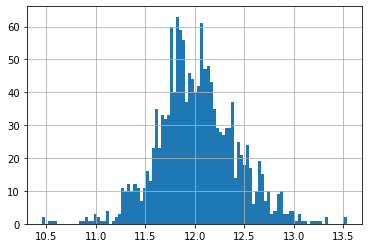

In [8]:
lGSalePrice.hist(bins=100);

### Historical price data

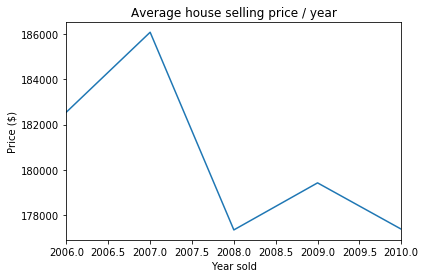

In [9]:
avg_price_per_year = train_set \
    .groupby(['YrSold'])['SalePrice'] \
    .mean() \
    .plot(
    kind='line',
    title='Average house selling price / year'
)
avg_price_per_year.set_xlabel("Year sold")
avg_price_per_year.set_ylabel("Price ($)");

The timeline chart clearly shows the significant drop of the average houses in the Iowa between 2007 and 2008.

The crisis in the US led to significant drop in house values - from average selling price equal to 186,000 US dollars in 2007 to about 178,000 US dollars in 2008. Whereas, it might not seem like a big price drop, it corresponds with Financial crisis of 2007-08.

## Correlation of features

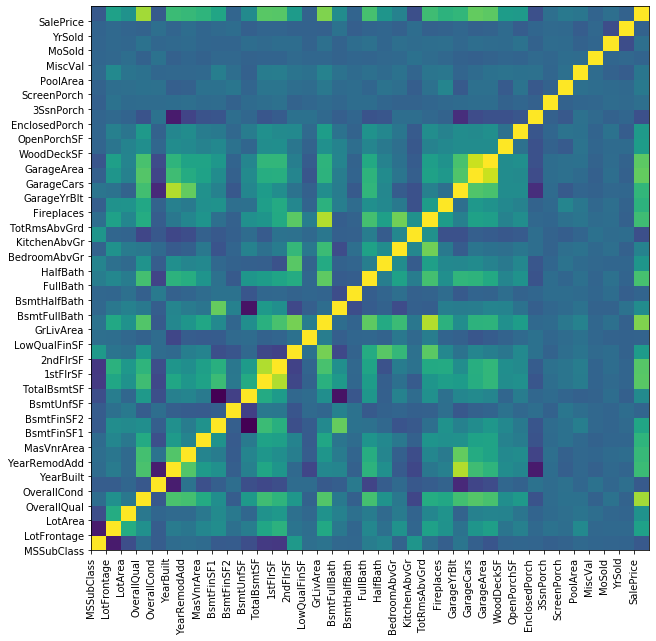

In [10]:
features_corr = train_set.drop(columns='Id').corr()
plt.pcolor(features_corr)
plt.xticks(list(range(0, len(features_corr.columns))), features_corr.columns, rotation=90)
plt.yticks(list(range(0, len(features_corr.columns))), features_corr.columns)
plt.gcf().set_size_inches(10, 10)

The above chart shows the correlation between all numerical features. Yellow colour shows perfect correlation, whereas dark blue/purple shows little or no correlation.

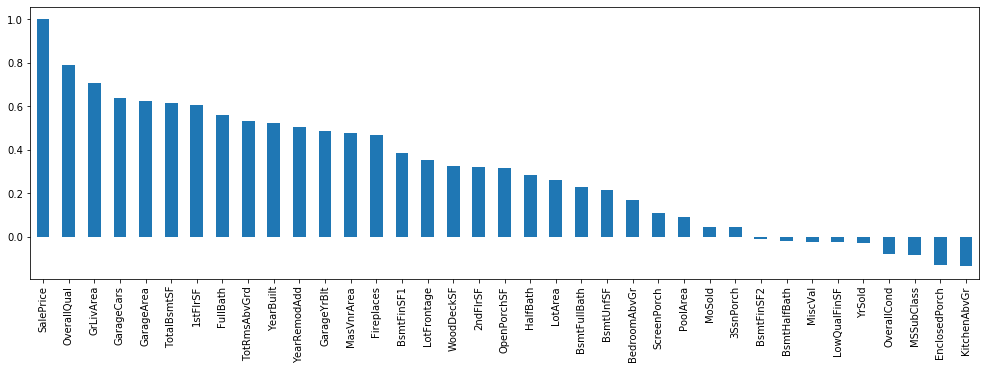

In [11]:
top_features_corr = features_corr['SalePrice'].sort_values(ascending=False)
top_features_corr.plot.bar(y='Feature', figsize=(17,5));

The following bar chart provides numerical feature correlation to the sale price. The factor with the greatest impact on the sale price is the **overall quality** of the flat with 80% correlation rate.

As provided in the description, this feature ranges from 10 (Very Excellent) to 1 (Very Poor). The next most important features are **above ground living area** (\~74% compatibility), **size of garage (car capacity)** (\~62%), **size of garage (sqr feet)**, **total basement area** and **first floor size (sqr feet)**.

On the other hand, features like **Month sold**, **Three season porch area**, **Year sold**, or **Kitchens above grade** has little, or no correlation to the final price.

The chart will be useful as number of unimportant features could be dropped if the machine learning model will have high-variance (over-fit) in the training example.

## Preparing data

### Introduction

Significant amount of columns contain categorical/enum values - i.e. code of type string that has specific meaning. Whereas it might be helpful for human, it makes the computation unnecessarily expensive. In the following section, dataset will be prepared for later analysis.

### Transformation pipeline

Specifically:

1. Id should be removed as not irrelevant for training purposes.

2. N/A/Empty values should be populated to avoid mathematical operations on empty cells/null data.

3. All numerical columns should be scaled.

4. Features with low/none correlation to the sale price should be removed.

5. Columns: *MSZoning*, *Street*, *Alley*, *LotShape*, *LandContour*, *Utilities*, *LatConfig*, *LandSlope*,	*Neighborhood*,	*Condition1*,	*Condition2*,	*BldgType*,	*HouseStyle*, *RoofStyle*, *RoofMatl*, *Exterior1st*, *Exterior2nd*, *MasVnrType*, *ExterQual*, *ExterCond*, *Foundation*, *BsmtQual*, *BsmtCond*, *BsmtExposure*, *BsmtFinType1*, *BsmtFinType2*, *Heating*, *HeatingQC*, *CentralAir*, *Electrical*, *KitchenQual*, *Functional*, *FireplaceQu*, *GarageType*, *GarageFinish*, *GarageQual*, *GarageCond*, *PavedDrive*, *PoolQC*, *Fence*, *MiscFeature*, *SaleType*, *SaleCondition* should be converted to numerical values.

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from house_prices_advanced_regression_techniques.label_remover import LabelRemover
from house_prices_advanced_regression_techniques.na_enum_mapper import NaEnumMapper
from house_prices_advanced_regression_techniques.dictionary_vectorizer import DictionaryVectorizer
from house_prices_advanced_regression_techniques.numerical_cleaner import NumericalCleaner

enum_column_names = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                     'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                     'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
                     'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
                     'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
                     'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
                     'SaleType', 'SaleCondition']

num_columns = list(set(train_set.drop(enum_column_names, axis=1).columns) - {'SalePrice'})

num_pipeline = Pipeline([
    ('id_rmv', LabelRemover(['Id'])),
    ('numerical_cleaner', NumericalCleaner()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('na_enum_mapper', NaEnumMapper(enum_column_names)),
    ("vectorizer", DictionaryVectorizer())
])

prep_pipeline = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ("num", num_pipeline, num_columns),
        ('cat', cat_pipeline, enum_column_names)
    ])

### Transforming data

In [13]:
prep_train_set = prep_pipeline.fit_transform(train_set.drop(columns = 'SalePrice'), train_set['SalePrice'])
print(f"Size of prepared train set: {np.shape(prep_train_set)}")

Size of prepared train set: (1460, 291)


## Importance of categorical features

### Introduction

Knowing which numerical features correlate best with the label (SalePrice) is very helpful, similarly SelectKBest algorithm can be used to find number of top X number of most important features in the dataset.

### Preparation

In [14]:
from sklearn.feature_selection import mutual_info_classif


transformed_X = cat_pipeline.fit_transform(train_set[enum_column_names])
feature_scores = mutual_info_classif(transformed_X, train_set['SalePrice'])
feature_names = cat_pipeline['vectorizer'].get_feature_names()

### Results


Total number of (vectorized) features: 267
Number of selected (vectorized) features: 54
Number of excluded features (importance < .2): 213



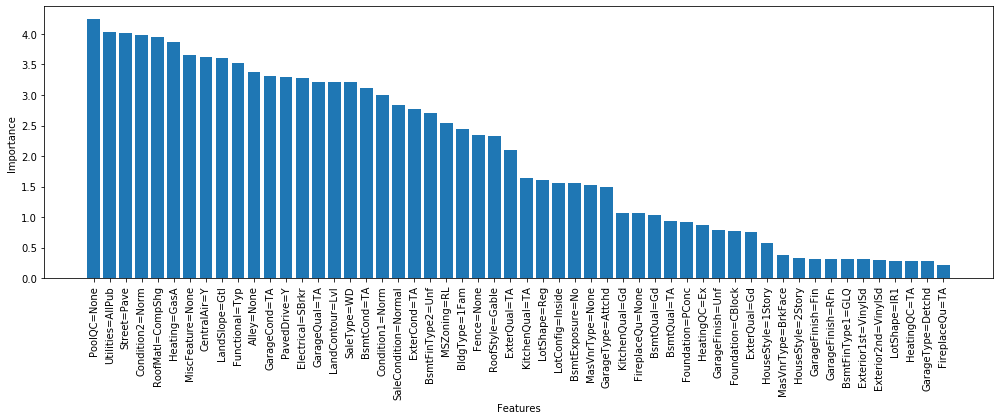

In [15]:
feature_ranking = sorted(zip(feature_scores, feature_names), reverse=True)
relevant_feature_ranking = list(filter(lambda x: x[0] > .2, feature_ranking))
relevant_feature_ranking_names = [val[1] for val in relevant_feature_ranking]
relevant_feature_ranking_scores = [val[0] for val in relevant_feature_ranking]

plt.gcf().set_size_inches(17, 5)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.bar(relevant_feature_ranking_names, relevant_feature_ranking_scores, align='center')
print(f'''
Total number of (vectorized) features: {len(feature_names)}
Number of selected (vectorized) features: {len(relevant_feature_ranking_names)}
Number of excluded features (importance < .2): {len(feature_names) - len(relevant_feature_ranking_names)}
''')

Just a few pre-processing and calculation steps provide very useful information. To start with 213 features have importance lower than 0.2. feature that has importance of 0.5 is 8 times less important than the most useful feature. There is no hard threshold to be used to consider a feature to be 'unimportant', but in the following research I decided to use .2 due to very big amount of features.

In total, just 54 features have been selected out of total 267.

The most important, five features that has impact on the final house price are:

1. Utilities=AllPub - A house has all public Utilities (Electricity, Gas, Water, & Sewage)
2. PoolQC=None - A house does not have any pool
3. Street=Pave - A road next to the hause is paved
4. Codition2=Norm - Normal proximity to various conditions
5. RoofMatl=ComShg - A house has standard (Composite) shingle roof

## Cleaning data

### Introduction

As seen previously, big number of features are not relevant and might lead to high variance (over-fitting) of the ML model.

The next pipeline will be used to remove numerical features with less than 35% of correlation value, as well as categorical features with importance less than 1.

### Transforming data

In [16]:
from house_prices_advanced_regression_techniques.category_cleaner import CategoryCleaner


cc = CategoryCleaner(feature_names)
clean_prep_train_set = cc.fit_transform(prep_train_set, train_set['SalePrice'])

## Machine learning models

After careful data preparation, number of ML models can be used to train using the prepared training data set.

Accordingly to lunch free theorem there is no one perfect model that will serve the purpose perfectly. Rather one need to check multiple solution and select the most promising one.

### Preparation

In [17]:
from sklearn.model_selection import train_test_split


train_label = np.log(train_set['SalePrice'])
X_train, X_test, Y_train, Y_test = train_test_split(clean_prep_train_set, train_label, test_size=0.2, random_state=42)
print(f'''
Size of train set: {np.shape(X_train)}
Size of test set: {np.shape(X_test)}
Size of train label vector: {np.shape(Y_train)}
Size of test label vector: {np.shape(Y_test)}
''')


Size of train set: (1168, 78)
Size of test set: (292, 78)
Size of train label vector: (1168,)
Size of test label vector: (292,)



### Linear regression

#### Training

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train);

#### Testing

In [19]:
from sklearn.metrics import mean_squared_error


Y_predicted = lin_reg.predict(X_test)
lin_mse = mean_squared_error(Y_test, Y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(f"Root Mean Squared Error: {lin_rmse}")

Root Mean Squared Error: 0.15602765435019736


Linear regression is definitely not the most appropriate model due to high number of features. Nevertheless, RMSE of ~0.16 is still not a bad result.

Increasing the training set might improve the temporal performance, but it will lead to high variance and very poor performance in test (submission) set.

### Decision Tree Regressor

#### Training

In [20]:
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, Y_train);

#### Testing

In [21]:
from sklearn.metrics import mean_squared_error


Y_predicted = tree_reg.predict(X_test)
lin_mse = mean_squared_error(Y_test, Y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(f"Root Mean Squared Error: {lin_rmse}")

Root Mean Squared Error: 0.21016106267444123


### Random Forest Regressor

#### Training

In [22]:
from sklearn.ensemble import RandomForestRegressor


forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, Y_train);

#### Testing

In [23]:
from sklearn.metrics import mean_squared_error

Y_predicted = forest_reg.predict(X_test)
lin_mse = mean_squared_error(Y_test, Y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(f"Root Mean Squared Error: {lin_rmse}")

Root Mean Squared Error: 0.15161228668031013


#### Tuning hyperparameters

In [24]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {'n_estimators': [3, 10, 30, 40, 50, 75, 95, 100],
     'max_depth': [4, 10, 20, 'None'],
     'max_features': ['None', 'auto', 'sqrt', 'log2'],
     'ccp_alpha': [0, 0.1, 0.3, 0.5]}
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, Y_train);

#### Re-Testing

In [25]:
best_forest_reg = grid_search.best_estimator_
Y_predicted = best_forest_reg.predict(X_test)
lin_mse = mean_squared_error(Y_test, Y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(f"Root Mean Squared Error: {lin_rmse}")

Root Mean Squared Error: 0.15989539086230956


### Gradient Boosting Regressor

#### Training

In [26]:
from sklearn.ensemble import GradientBoostingRegressor


grad_reg = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=.05, loss='ls')
grad_reg.fit(X_train, Y_train);

#### Testing

In [27]:
Y_predicted = grad_reg.predict(X_test)
lin_mse = mean_squared_error(Y_test, Y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(f"Root Mean Squared Error: {lin_rmse}")
print(f"Score: {grad_reg.score(X_test, Y_test)}")

Root Mean Squared Error: 0.14776220803007745
Score: 0.883000597561639


## Submission

### Introduction

As part of the competition, Kaggle provides test csv file that should be used to generate csv file with 2 columns - ID and predicted price.

The following code will save the csv file to /submission folder that is excluded from git tracking.

In [28]:
from house_prices_advanced_regression_techniques.load_data import load_data


test_set = load_data('./dataset', 'test.csv')
test_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Preparation

In [29]:
from house_prices_advanced_regression_techniques.category_cleaner import CategoryCleaner


prep_test_set = prep_pipeline.transform(test_set)
clean_prep_test_set = cc.transform(prep_test_set)

### Prediction

In [30]:
test_Y_predicted = np.exp(grad_reg.predict(clean_prep_test_set))

Exponential (exp) function is the reverse of logarithm function and is needed to calculate the actual price.

### Submission

In [31]:
import pandas as pd


predicted_prices = pd.DataFrame({
    'Id': test_set['Id'],
    'SalePrice': test_Y_predicted
})

predicted_prices.head()

,Id,SalePrice
0,1461,122513.026831
1,1462,154732.224285
2,1463,180937.346231
3,1464,187185.782220
4,1465,202130.880853


### Saving / Exporting

In [32]:
import os


outdir = './submission'

# Uncomment to create a csv file

# if not os.path.exists(outdir):
#     os.mkdir(outdir)
# predicted_prices.to_csv(index=False, path_or_buf=f'{outdir}/submission.csv')

The first submission of the dataset was graded with 0.14850 on Kaggle which corresponds with score predicted on the training set.